<a href="https://colab.research.google.com/github/lucaspauker/sympathetic-flaring-research/blob/master/Research_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Downloading Data

Import libraries necessary for this section

In [89]:
# If using Google Colab, need to store files in drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from urllib.request import urlopen
from datetime import datetime, timedelta

import pandas
import requests
import json
import csv
import pickle
import time
import random

import matplotlib.pyplot as plt
import numpy as np

Mounted at /content/drive


Here are the methods used to upload data. Data was generated using the methods shown here: https://github.com/lucaspauker/hmi-time-series-analysis/blob/master/time_series_data_analysis.ipynb

In [0]:
def get_harp_ids_and_harp_noaa_dict(filepath):
    '''This method requires there to be a file filename with two columns: HARP IDs
    and NOAA IDs. This method returns a list of HARP IDs and a dictionary of HARP
    IDs corresponding to a list of NOAA IDs.
    '''
    harp_ids = []
    harp_noaa_dict = {}
    with open(filepath, 'r') as f:
      for i, line in enumerate(f.readlines()):
        if i < 1: continue
        harp_id = line.split()[0]
        noaa_ids = line.split()[1].split(',')
        harp_ids.append(int(harp_id))
        harp_noaa_dict[int(harp_id)] = noaa_ids
    return harp_ids, harp_noaa_dict

In [0]:
def convert_tai_to_datetime(t_str):
    '''Helper method to convert a JSOC T_REC object into a python datetime object.'''
    year   = int(t_str[:4])
    month  = int(t_str[5:7])
    day    = int(t_str[8:10])
    hour   = int(t_str[11:13])
    minute = int(t_str[14:16])
    return datetime(year, month, day, hour, minute)

In [0]:
def convert_datetime_to_tai(t_obj):
    '''Helper method to convert a datetime object into a JSOC T_REC object.'''
    return str(t_obj.year) + '.' + str(t_obj.month) + '.' + str(t_obj.day) + '_' \
            + str(t_obj.hour) + ':' + str(t_obj.minute) + '_TAI'

In [0]:
def read_data(harp_id):
    '''This method reads the data from FILEPATH_BASE/[harp_id].csv, and returns a pandas
    DataFrame with time since the beginning of the active region as well as data
    corresponding to each time point.
    '''
    filename = FILEPATH_BASE + str(harp_id) + '.csv'
    df = pandas.read_csv(filename)
    df.TRUE_TIME = df.TRUE_TIME.map(convert_tai_to_datetime)
    for i, row in df.iterrows():
        if 'MISSING' in row.values:
            df = df.drop(i)
    df = df.reset_index()
    return df

In [0]:
def get_noaa_data_from_csv():
    '''This method loads the NOAA data from FILEPATH_BASE/noaa_data.csv.'''
    noaa_flare_set = []
    with open(FILEPATH_BASE + 'noaa_data.csv', 'r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            noaa_flare_set.append(dict(row))
    return noaa_flare_set

In [10]:
# Where data is stored
FILEPATH_BASE = '/content/drive/My Drive/data/'

harp_noaa_filepath = FILEPATH_BASE + 'all_harps_with_noaa_ars.txt'
harp_ids, harp_noaa_dict = get_harp_ids_and_harp_noaa_dict(harp_noaa_filepath)
flare_data = get_noaa_data_from_csv()
print('Number of active regions:', len(harp_ids))
print('Number of flares:', len(flare_data))

Number of active regions: 1335
Number of flares: 8029


In [0]:
def get_time_delta(start_time, end_time):
    '''This method returns the time difference between two given datetime objects in
    hours.
    '''
    return (end_time - start_time).total_seconds() / (60 * 60) # Convert to hours

In [0]:
def get_flared_noaa_id_set(flare_data, min_class=None):
    '''This method returns a list of all the NOAA IDs that have flared, based
    on the data passed in from flare_data.
    '''
    noaa_flare_set = set()
    for flare in flare_data:
      goes_class = flare['goes_class']
      classes = ['c', 'm', 'x']
      if (
          not min_class or
          classes.index(goes_class[0].lower()) > classes.index(min_class[0].lower()) or
          (classes.index(goes_class[0].lower()) == classes.index(min_class[0].lower()) and
          float(goes_class[1:]) >= float(min_class[1:]))
      ):
        noaa_flare_set.add(int(flare['noaa_active_region']))
    return noaa_flare_set

In [0]:
def has_flared(harp_id, harp_noaa_dict, noaa_flare_set):
    '''This method returns a boolean corresponding to whether the active region
    corresponding to the harp_id has flared or not within its lifespan.
    '''
    for noaa_id in harp_noaa_dict[harp_id]:
        if int(noaa_id) in noaa_flare_set:
            return True
    return False

In [0]:
def get_harp_id_to_flaring_times_dict(harp_ids, harp_noaa_dict, flare_data):
    '''This method returns a dictionary where the keys are HARP IDs and
    the values are a list of times where the given active region flared. Each
    value in the list is a two-element array of [start_time, end_time]

    If the active region corresponding to the HARP IDs did not flare, then
    the list corresponding to the active region will be empty.

    Since the GOES flare database corresponds to NOAA IDs, but the SHARP database 
    corresponds to HARP IDs (i.e. there are two ways of naming ARs), connecting
    the flares to HARP IDs must be done in two steps.
      1. Make dictionary of NOAA IDs -> flare times
      2. Make dictionary of HARP IDs -> flare times
    '''
    # Make a dictionary of NOAA ids as keys and flare times as values
    noaa_id_flare_time_dict = {}
    for flare in flare_data:
        start_time = flare['start_time']
        end_time = flare['end_time']
        noaa_id = int(flare['noaa_active_region'])
        if noaa_id in noaa_id_flare_time_dict.keys():
            noaa_id_flare_time_dict[noaa_id] += [[start_time, end_time]]
        else:
            noaa_id_flare_time_dict[noaa_id] = [[start_time, end_time]]

    # Make a dictionary with HARP IDs as keys and flare times as values
    flare_time_dict = {}
    noaa_ids = noaa_id_flare_time_dict.keys()
    for harp_id in harp_ids:
        keys = read_data(harp_id)
        if len(keys.TRUE_TIME) == 0:  # Check that len(data) > 0 for harp_id
            flare_time_dict[harp_id] = []
            continue

        flare_time_dict[harp_id] = []
        for noaa_id in harp_noaa_dict[harp_id]:
            if int(noaa_id) not in noaa_ids: continue
            flare_time_dict[harp_id] += noaa_id_flare_time_dict[int(noaa_id)]
    return flare_time_dict

In [0]:
from math import log10
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

###Main Data Download

In [36]:
VARIABLES = ['USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD',
             'TOTUSJZ', 'MEANJZH', 'TOTUSJH', 'ABSNJZH', 'SAVNCPP', 'MEANPOT',
             'TOTPOT', 'MEANSHR', 'SHRGT45', 'R_VALUE' ,'AREA_ACR']

RAW_VARIABLE_DATA = pandas.DataFrame()

WHICH_AR = []            # List length equal to RAW_VARIABLE_DATA with which AR
                         # each data point corresponds to
TIMES = []               # List length equal to RAW_VARIABLE_DATA with times for
                         # each data point
DID_FLARE_LIST = []      # List length equal to RAW_VARIABLE_DATA with whether
                         # each data point is during a flare

AR_START_END_TIMES = {}  # Starting and ending times for each AR
VARIABLE_DATA_DICT = {}  # Dictionary with keys HARP IDs and values of the
                         # VARIABLES for each time point
AR_TIME_DICT = {}        # Dictionary with keys HARP IDs and values of times for
                         # the AR
DID_FLARE_DICT = {}      # Dictionary with keys HARP IDs and values of whether
                         # each data point is during a flare for the AR

max_range = len(harp_ids)  # Only create data for max_range HARP IDs
init_time = time.time()  # Record the time the method takes

for i, harp_num in enumerate(harp_ids[:max_range]):
  if ((i + 1) % 100 == 0): print(i + 1, '/', len(harp_ids), 'HARP IDs processed')

  time_series_data = read_data(harp_num)
  WHICH_AR += [harp_num] * len(time_series_data)  # All points correspond to
                                                  # harp_num AR
  
  AR_TIME_DICT[harp_num] = []
  for _, row in time_series_data.iterrows():  # Don't need index
    TIMES.append(row['TRUE_TIME'])  # Each row is a datapoint with VARIABLES data
    AR_TIME_DICT[harp_num].append(row['TRUE_TIME'])

  single_flare_list = [0] * len(time_series_data)  # Data about flaring for AR
  if harp_num in flare_time_dict:  # If this AR has flared
    for j, row in time_series_data.iterrows():  # Each row is a datapoint with
                                                # VARIABLES data
      for flare in flare_time_dict[harp_num]:
        start_time = flare[0]
        end_time = flare[1]
        # Check if start_time - true_time < 0 and end_time - true_time > 0
        # This checks if true_time occurs during the flare
        if get_time_delta(row['TRUE_TIME'], convert_tai_to_datetime(start_time)) < 0 and\
            get_time_delta(row['TRUE_TIME'], convert_tai_to_datetime(end_time)) > 0:
            single_flare_list[j] = 1  # Default is zero, as set above
  DID_FLARE_LIST += single_flare_list
  DID_FLARE_DICT[harp_num] = single_flare_list

  RAW_VARIABLE_DATA = RAW_VARIABLE_DATA.append(time_series_data[VARIABLES],
                                                ignore_index=True)
  VARIABLE_DATA_DICT[harp_num] = np.array(time_series_data[VARIABLES])

  if len(list(time_series_data['TRUE_TIME'])) < 2: continue
  AR_START_END_TIMES[harp_num] = (list(time_series_data['TRUE_TIME'])[0],
                                  list(time_series_data['TRUE_TIME'])[-1])

print(round(time.time() - init_time, 2), 'seconds elapsed')
print(len(RAW_VARIABLE_DATA), 'data points in total')

100 / 1335 HARP IDs processed
200 / 1335 HARP IDs processed
300 / 1335 HARP IDs processed
400 / 1335 HARP IDs processed
500 / 1335 HARP IDs processed
600 / 1335 HARP IDs processed
700 / 1335 HARP IDs processed
800 / 1335 HARP IDs processed
900 / 1335 HARP IDs processed
1000 / 1335 HARP IDs processed
1100 / 1335 HARP IDs processed
1200 / 1335 HARP IDs processed
1300 / 1335 HARP IDs processed
1471.21 seconds elapsed
1199590 data points in total


## Probability of Flares Occuring After Sympathetic Flares

One question that is interesting and deserves attention is if the probability of a flare increases with the occurrence of a flarPPe on another part of the sun (a sympathetic flare). The method `get_probabilities` calculates the probability of a flare occuring n hours after a sympathetic flare. It also calculates the probability a flare will occur on its own.

We can think of these two probabilities using standard notation as *P(flare|sympathetic flare in the last n hours)* and *P(flare)*, respectively.

What we find is that *P(flare|sympathetic flare in the last n hours)*>*P(flare)* for up to about 48 hours. This provides evidence that sympathetic flares increase the probability of a flare occuring on another part of the sun.



In [0]:
def get_probabilities(n_list=[60], frac=1):
  '''Returns the probability that a flare will occur within n timesteps after
  a sympathetic flare and the probability that a flare will occur.

  Runs the method on frac of ARs. For example, if frac=0.7, it will pick a random
  70% of ARs to run the model on.
  '''
  ARS = list(AR_TIME_DICT.keys())
  ar_list = np.random.choice(ARS, size=int(frac * len(ARS)), replace=False)

  num_flared_and_symp = {}  # Number of flares within n timesteps after symp flare
  flared_and_symp_data_points = {}  # Number of timesteps after symp flare
  for n in n_list:
    num_flared_and_symp[n] = 0
    flared_and_symp_data_points[n] = 0

  num_flared_tot = 0  # Total number of flares
  tot_data_points = 0  # Total number of timesteps

  for ar in ar_list:
    ar_times = AR_TIME_DICT[ar]
    if len(ar_times) == 0: continue

    concurrent_ars = []

    # Find which other ARs occur on the sun at the same time as the given AR
    for other_ar in ARS:
      if other_ar == ar: continue
      if len(AR_TIME_DICT[other_ar]) == 0: continue
      start_time = AR_TIME_DICT[other_ar][0]
      end_time = AR_TIME_DICT[other_ar][-1]
      if ar_times[0] < end_time and ar_times[-1] > start_time:
        concurrent_ars.append(other_ar)

    # Make a list of all the flaring times of an AR (binary list)
    symp_flare_indices = []  # Sympathetic flaring indices
    curr_flare_indices = []  # Active flaring indices
    for c, time in enumerate(ar_times):
      symp_flare_data_point = 0
      for conc_ar in concurrent_ars:
        if time in AR_TIME_DICT[conc_ar]:
          index = AR_TIME_DICT[conc_ar].index(time)
          symp_flare_data_point += DID_FLARE_DICT[conc_ar][index]
      if symp_flare_data_point > 0: symp_flare_indices.append(c)
      if DID_FLARE_DICT[ar][c] > 0: curr_flare_indices.append(c)

    # Count number of flares and update probabilities
    symp_data = []
    curr_data = []
    for i in curr_flare_indices:  # Iterate through flares for AR
      num_flared_tot += 1
      for n in n_list:
        for f_index in symp_flare_indices:
          if i >= f_index and abs(i - f_index) < n:
            num_flared_and_symp[n] += 1  # Flare that occurs within n timesteps
                                         # of a sympathetic flare
            break
    tot_data_points += len(DID_FLARE_DICT[ar])
    for n in n_list:
      for i, curr_index in enumerate(reversed(curr_flare_indices)):
        # We don't want to double count timesteps
        if i == 0:
          flared_and_symp_data_points[n] += n
        else:
          flared_and_symp_data_points[n] += min(n, list(reversed(curr_flare_indices))[i - 1] - curr_index)
  return num_flared_tot, tot_data_points, num_flared_and_symp, flared_and_symp_data_points

In [0]:
# Run probability calculations for n=10,20,40,80,160,320,640,1280 trained on
# 70% of the data

init_time = time.time()

for t in range(10):
  print('TRIAL', t)
  _, _, num_flared_and_symp, flared_and_symp_data_points = get_probabilities(n_list=[10,20,40,80,160,320,640,1280], frac=0.7)
  for i in list(num_flared_and_symp.keys()):
    print(i)
    print(num_flared_and_symp[i], flared_and_symp_data_points[i], num_flared_and_symp[i] / flared_and_symp_data_points[i])
    print()

print(round(time.time() - init_time, 2), 'seconds elapsed')

# PCA Analysis

By running PCA, we can understand how the data is structured better. One fact about the SHARP data is that many of the variables depend on eachother. By using PCA, we can calculate the principal components of the data, and see how well we can reconstruct the dataset with these principal components.

For example, if we have 10 total variables and we see that with 5 latent variables (variables calculated from PCA) we can construct the entire dataset, then we know that many of the variables depend on eachother and we can explain the data with only 5 dimensions instead of 10.

##Reconstruction Loss vs. Number of Latents

How does the reconstruction loss (loss when calculating origin dataset using latent variables) change when we increase the number of latent variables? We expect this to decrease as we add more latent variables.

In [0]:
from math import log10
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

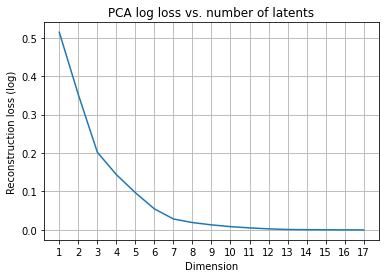

In [30]:
# Normalize data such that all the column (variable) vectors are unit vectors 
# with mean 0

def get_pca_errors(data):
  '''Returns a list of the reconstruction loss when PCA is run with varying
  numbers of components.
  '''
  scaler = StandardScaler()
  scaler.fit(data)
  variable_data = scaler.transform(data)

  error_data = []
  for i in range(1, len(VARIABLES) + 1):
    pca = PCA(n_components=i)
    pca.fit(variable_data)

    # Apply PCA fit to data
    X_train_pca = pca.transform(variable_data)
    X_projected = pca.inverse_transform(X_train_pca)
    loss = ((variable_data - X_projected) ** 2).mean()
    error_data.append(loss)
  return error_data

error_data = get_pca_errors(RAW_VARIABLE_DATA)
x_data = list(range(1, len(VARIABLES) + 1))
# error_data = [log10(e) for e in error_data]
fig, ax = plt.subplots()
plt.xlabel('Dimension')
plt.ylabel('Reconstruction loss (log)')
ax.set_title('PCA log loss vs. number of latents')
ax.xaxis.set_ticks(x_data)
ax.plot(x_data, error_data)
plt.grid()
plt.show()

# If T=XW, pca.components_ is the matrix W
# print(pca.components_)

##Histogram of Latent Variable Weights vs. Number of Latents

What real variables are the latent variables composed of?

In [0]:
def get_components(data):
  '''Get components of PCA run on the inputted data. PCA is computed with
  len(VARIABLES) components.
  '''
  pca = PCA(n_components=len(VARIABLES))
  pca.fit(data)
  return pca.components_

def create_histogram(data, errors=None):
  '''Creates a histogram of latent variable weights vs number of latents.
  '''
  print('Number of latent vars:', len(VARIABLES))
  components = get_components(data)

  column_data = []
  for component in components:
    for i in range(len(component)):
      if len(column_data) > i:
        column_data[i].append(component[i])
      else:
        column_data.append([component[i]])

  # Create histogram
  width = 0.8
  fig, ax = plt.subplots()
  ind = np.arange(1, len(column_data) + 1)
  for i, col in enumerate(column_data):
    if errors:
      ax.bar(ind - ((len(column_data))/2 - i) * width / (len(column_data)), col, width / (len(column_data)),
            label=VARIABLES[i], yerr=errors[i])
    else:
      ax.bar(ind - ((len(column_data))/2 - i) * width / (len(column_data)), col, width / (len(column_data)),
            label=VARIABLES[i])
  x_data = list(range(1, len(VARIABLES) + 1))

  fig.set_size_inches(50, 10.5)
  plt.xlabel('Dimension')
  plt.ylabel('Per-variable weight')
  ax.set_title('PCA log loss vs. number of latents')
  ax.xaxis.set_ticks(x_data)
  ax.legend(loc="upper left")
  plt.show()

In [0]:
def add_noise(variable_data, std=None):
  '''Adds noise to the inputted data. We can use this to see if the PCA weights
  change as we add noise as a robustness check.

  variable_data must be centered at 0 and normalized.
  '''
  noisy_variable_data = []
  for feature in variable_data.T:
    noisy_variable_data.append([])
    feat_std = np.std(feature)
    for pt in feature:
      if std:
        noisy_variable_data[-1].append(pt + random.gauss(0, std))
      else:
        noisy_variable_data[-1].append(pt + random.gauss(0, feat_std))
  return np.array(noisy_variable_data).T

. . . . . . . . . . 
Number of latent vars: 17


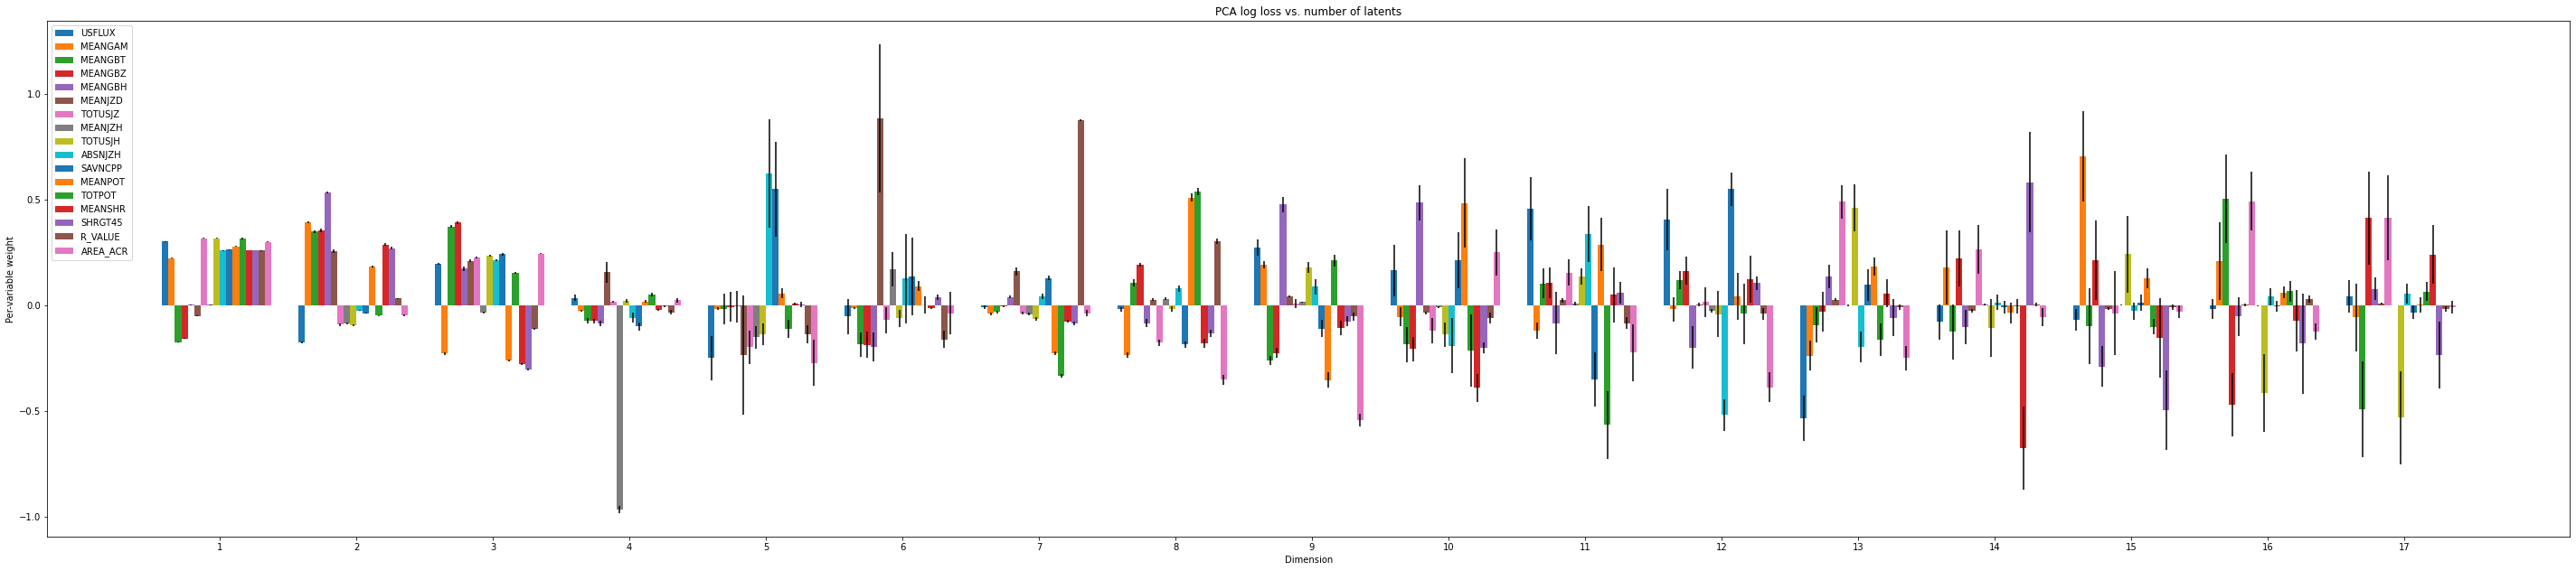

In [40]:
scaler = StandardScaler()
scaler.fit(RAW_VARIABLE_DATA)
variable_data = scaler.transform(RAW_VARIABLE_DATA)
variable_data = add_noise(variable_data)

n = 10
k = 0.1
# This is a list of n component matrices that are each generated from k % of the
# data. Therefore, this is a 3D array (array of 2D arrays).
components_list = []
for _ in range(n):
  print(".", end =" ")
  slice_indices = np.random.choice(len(variable_data), int(len(variable_data) * k), replace=False)
  data_slice = []
  for i in slice_indices:
    data_slice.append(variable_data[i])
  components_list.append(get_components(data_slice))
print()

std_matrix = np.empty([len(components_list[0]), len(components_list[0][0])])
for i in range(len(components_list[0])):
  for j in range(len(components_list[0][0])):
    # List of all data points at specific (i,j) position. Length n.
    position_list = []
    for m in range(n):
      position_list.append(components_list[m][i][j])
    std_matrix[i][j] = np.std([abs(x) for x in position_list])

column_stds = []
for stds in std_matrix:
  for i in range(len(stds)):
    if len(column_stds) > i:
      column_stds[i].append(stds[i])
    else:
      column_stds.append([stds[i]])
create_histogram(variable_data, errors=column_stds)

##Latent Variable over Time (w/ Flares)

How do the latent variables look for certain active regions over time?

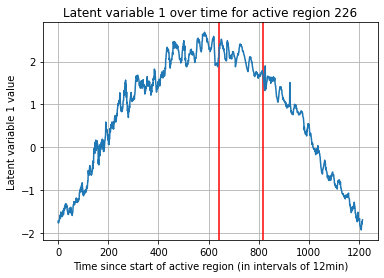

In [64]:
harp_num = 226

scaler = StandardScaler()
scaler.fit(RAW_VARIABLE_DATA)
variable_data = scaler.transform(RAW_VARIABLE_DATA)

flaring_indices = np.where(np.array(DID_FLARE_DICT[harp_num]) == 1)[0]

pca = PCA(n_components=len(VARIABLES))
pca.fit(variable_data)
latent_data = pca.transform(single_variable_data)

# Index of latent variable we want to graph
latent_var_num = 1
y_data = []
for l in latent_data:
  y_data.append(l[latent_var_num])
x_data = list(range(len(y_data)))

fig, ax = plt.subplots()
for i in flaring_indices:
  ax.axvline(x=i, color='r')
ax.set_title('Latent variable ' + str(latent_var_num) + ' over time for active region ' + str(harp_num))
plt.xlabel('Time since start of active region (in intervals of 12min)')
plt.ylabel('Latent variable ' + str(latent_var_num) + ' value')
plt.grid()
plt.plot(x_data, y_data)
plt.show()

##Density Plots of Latent Variables

Now we can create graphs of 2 latent features (1 per axis) and see how they correlate. We can see if we can find a difference in how the flaring data and non flaring data behave.

In [0]:
def get_data(first_var, second_var, X_r):
  '''Return flaring and non flaring data for the two inputted variable indices.
  X_r inputted is the latent PCA data.
  '''
  first_var_data_flare = []
  second_var_data_flare = []
  first_var_data_nonflare = []
  second_var_data_nonflare = []
  for i, row in enumerate(X_r):
    if DID_FLARE_LIST[i]:
      first_var_data_flare.append(row[first_var])
      second_var_data_flare.append(row[second_var])
    else:
      first_var_data_nonflare.append(row[first_var])
      second_var_data_nonflare.append(row[second_var])
  return first_var_data_flare, second_var_data_flare, first_var_data_nonflare, second_var_data_nonflare

In [0]:
def make_plots(first_var, second_var, X_r):
  '''first_var is the first latent variable index, second_var is the second latent
  variable index. This method plots these two variables against eachother for
  both flaring and nonflaring data. X_r is the latent data.
  '''
  first_var_data_flare, second_var_data_flare, first_var_data_nonflare, second_var_data_nonflare = get_data(first_var, second_var, X_r)
  alph = 0.01

  fig, ax = plt.subplots()
  plt.xlabel('Latent variable ' + str(first_var) + ' value')
  plt.ylabel('Latent variable ' + str(second_var) + ' value')
  ax.set_title('NONFLARING Latent variable ' + str(first_var) + ' vs. Latent variable ' + str(second_var))
  plt.scatter(first_var_data_nonflare, second_var_data_nonflare, color='black', alpha=alph, s=5)
  fig.set_size_inches(8, 6)
  plt.grid()
  plt.show()

  fig, ax = plt.subplots()
  plt.xlabel('Latent variable ' + str(first_var) + ' value')
  plt.ylabel('Latent variable ' + str(second_var) + ' value')
  ax.set_title('FLARING Latent variable ' + str(first_var) + ' vs. Latent variable ' + str(second_var))
  plt.scatter(first_var_data_flare, second_var_data_flare, color='black', alpha=alph, s=5)
  fig.set_size_inches(8, 6)
  plt.grid()
  plt.show()

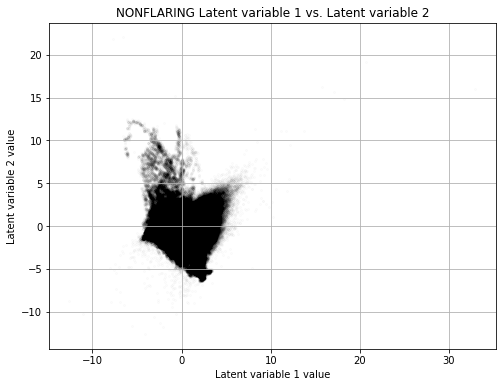

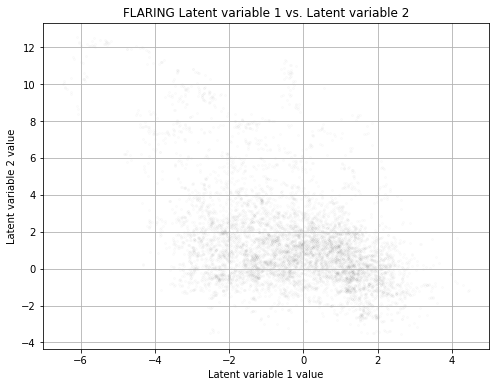

In [84]:
scaler = StandardScaler()
scaler.fit(RAW_VARIABLE_DATA)
variable_data = scaler.transform(RAW_VARIABLE_DATA)

pca = PCA(n_components=len(VARIABLES))
X_r = pca.fit(variable_data).transform(variable_data)

make_plots(1, 2, X_r)

# Sympathetic Flaring Feature

We are interested in finding if using sympathetic flaring data as a feature in a flare prediction model will improve our accuracy. To do this analysis, we first need to create the sympathetic flaring feature.

In [0]:
def get_flaring_sympathetic_feature(ar):
  '''Creates a sympathetic feature describing flaring activity on the sun for
  active regions excluding the inputted ar. The sympathetic feature corresponds
  to 1 / t where t represents the shortest time to a sympathetic flare.

  This method returns the sympathetic feature as well as the current feature
  for the AR. The current feature data also has a 1 / t relationship where t
  represents the shortest time to a flare for the inputted ar.
  '''
  ar_times = AR_TIME_DICT[ar]
  if len(ar_times) == 0: return [], []
  
  ARS = list(AR_TIME_DICT.keys())
  concurrent_ars = []

  # Find which other ARs occur on the sun at the same time as the given AR
  for other_ar in ARS:
    if other_ar == ar: continue  # Exclude given AR
    if len(AR_TIME_DICT[other_ar]) == 0: continue
    start = AR_TIME_DICT[other_ar][0]
    end = AR_TIME_DICT[other_ar][-1]
    if ar_times[0] < end and ar_times[-1] > start:
      concurrent_ars.append(other_ar)

  # Make a list of all the flaring times of an AR (0s and 1s)
  symp_flaring_data = []
  curr_flaring_data = []
  symp_flare_indices = []  # When sympathetic flares occured
  curr_flare_indices = []  # When flares occured for ar
  c = 0  # index
  for time in ar_times:
    symp_flare_data_point = 0
    curr_flare_data_point = 0
    inc_time = False
    for conc_ar in concurrent_ars:
      if time in AR_TIME_DICT[conc_ar]:
        inc_time = True
        index = AR_TIME_DICT[conc_ar].index(time)
        symp_flare_data_point += DID_FLARE_DICT[conc_ar][index]
    if inc_time:  # Only include in feature the times where there was another
                  # active region on the sun
      curr_index = AR_TIME_DICT[ar].index(time)
      symp_flaring_data.append(symp_flare_data_point)
      curr_flaring_data.append(DID_FLARE_DICT[ar][curr_index])
      if symp_flare_data_point > 0: symp_flare_indices.append(c)
      if DID_FLARE_DICT[ar][curr_index] > 0: curr_flare_indices.append(c)
      c += 1

  # Make list reflect 1 / t relationship, where t is the number of timesteps
  symp_data = []
  curr_data = []
  for i in range(len(curr_flaring_data)):  # len(curr_flaring_data) == len(symp_flaring_data)
    max_symp_inverse_dist = 0
    max_curr_inverse_dist = 0
    for f_index in symp_flare_indices:
      if f_index == i:
        max_symp_inverse_dist = 1
        break
      if 1 / float(abs(f_index - i)) > max_symp_inverse_dist:
        max_symp_inverse_dist = 1 / float(abs(f_index - i))
    for f_index in curr_flare_indices:
      if f_index == i:
        max_curr_inverse_dist = 1
        break
      if 1 / float(abs(f_index - i)) > max_curr_inverse_dist:
        max_curr_inverse_dist = 1 / float(abs(f_index - i))
    symp_data.append(max_symp_inverse_dist)
    curr_data.append(max_curr_inverse_dist)

  return symp_data, curr_data

In [106]:
ARS = list(AR_TIME_DICT.keys())

symp_flare_data_dict = {}  # Keys are HARP_IDs, values are sympathetic feature data
curr_flare_data_dict = {}  # Keys are HARP_IDs, values are current feature data

init_time = time.time()
for ar in ARS:
  print('AR:', ar)
  print(round(time.time() - init_time, 2), 'seconds elapsed')
  symp_feature, curr_feature = get_flaring_sympathetic_feature(ar)
  symp_flare_data_dict[ar] = symp_feature
  curr_flare_data_dict[ar] = curr_feature

print(round(time.time() - init_time, 2), 'seconds elapsed')

AR: 1
0.0 seconds elapsed
AR: 2
0.3 seconds elapsed
AR: 6
0.39 seconds elapsed
AR: 8
0.48 seconds elapsed
AR: 10
0.64 seconds elapsed
AR: 11
0.75 seconds elapsed
AR: 12
0.8 seconds elapsed
AR: 14
1.08 seconds elapsed
AR: 17
1.13 seconds elapsed
AR: 26
1.21 seconds elapsed
AR: 38
1.3 seconds elapsed
AR: 40
1.55 seconds elapsed
AR: 41
1.72 seconds elapsed
AR: 43
1.74 seconds elapsed
AR: 45
1.91 seconds elapsed
AR: 46
2.03 seconds elapsed
AR: 49
2.25 seconds elapsed
AR: 51
2.3 seconds elapsed
AR: 54
2.34 seconds elapsed
AR: 57
2.36 seconds elapsed
AR: 58
2.49 seconds elapsed
AR: 67
2.55 seconds elapsed
AR: 71
2.67 seconds elapsed
AR: 83
2.8 seconds elapsed
AR: 86
2.85 seconds elapsed
AR: 89
2.97 seconds elapsed
AR: 92
3.01 seconds elapsed
AR: 98
3.33 seconds elapsed
AR: 104
3.51 seconds elapsed
AR: 107
3.98 seconds elapsed
AR: 114
4.39 seconds elapsed
AR: 115
4.86 seconds elapsed
AR: 116
5.37 seconds elapsed
AR: 128
5.83 seconds elapsed
AR: 131
6.29 seconds elapsed
AR: 135
6.62 seconds el

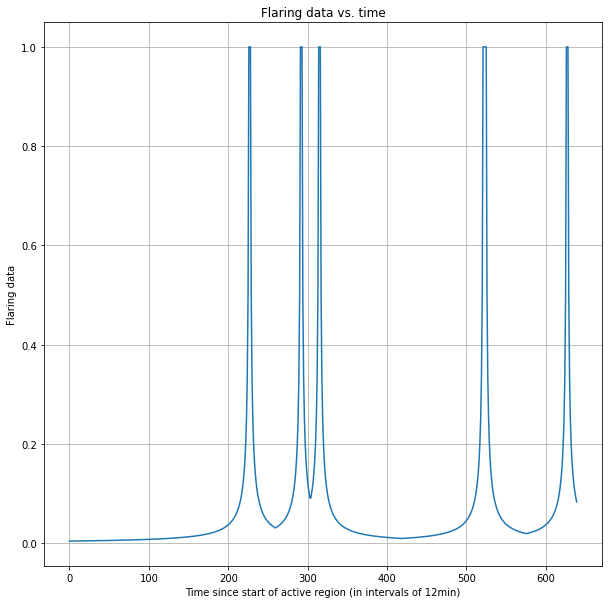

In [101]:
# Plot feature data

ar = 8
data = curr_flare_data_dict[ar]
# data = symp_flare_data_dict[ar]

fig, ax = plt.subplots()
fig.set_size_inches(10,10)
plt.xlabel('Time since start of active region (in intervals of 12min)')
plt.ylabel('Flaring data')
ax.set_title('Flaring data vs. time')
ax.plot(range(len(data)), data)
plt.grid()
plt.show()

# VAR Model Building

We use the Statsmodel VAR package to create multivariable autoregressive models with and without sympathetic features.

In [113]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Build Dataset

In [0]:
def build_flare_dataset(curr_flare_data_dict, symp_flare_data_dict):
  data_dict = {}
  for ar in AR_TIME_DICT.keys():
    data_dict[ar] = np.transpose(np.concatenate(([curr_flare_data_dict[ar]], [symp_flare_data_dict[ar]]), axis=0))
  return data_dict

In [0]:
def get_single_data_array(data_dict, lag_order=10):
  '''Given the data_dict with ARs mapped to data, creates an aggregate single
  list with lag_order of whitespace (zeros) between entries
  '''
  # Combine data into a single array
  raw_data = None

  keys = list(data_dict.keys())
  random.seed(1729)
  random.shuffle(keys)
  zero_list = []  # Places we have to add zeros for the data after normalizing

  c = 0
  for ar in keys:
    c += 1
    if raw_data is not None:
      zero_list.append(len(raw_data))
      raw_data = np.concatenate((raw_data, data_dict[ar]), axis=0)
    else:
      raw_data = data_dict[ar]

  # Scale data
  raw_data = np.array(raw_data).astype(float)
  scaler = StandardScaler()
  scaler.fit(raw_data)
  raw_data = scaler.transform(raw_data)

  # Add zeros
  new_data = []
  zeros = np.zeros((lag_order, len(raw_data[0])))

  new_data = raw_data[:zero_list[0]]
  for i in range(1, len(zero_list)):
    new_data = np.concatenate((new_data, zeros), axis=0)
    new_data = np.concatenate((new_data, raw_data[zero_list[i - 1]: zero_list[i]]), axis=0)
  new_data = np.concatenate((new_data, zeros), axis=0)
  new_data = np.concatenate((new_data, raw_data[zero_list[-1]:]), axis=0)

  raw_data = new_data
  return raw_data

In [0]:
data_dict = build_flare_dataset(curr_flare_data_dict, symp_flare_data_dict)

In [109]:
LAG_ORDER = 10

raw_data = get_single_data_array(data_dict, lag_order=LAG_ORDER)
print(raw_data.shape)

(1155802, 2)


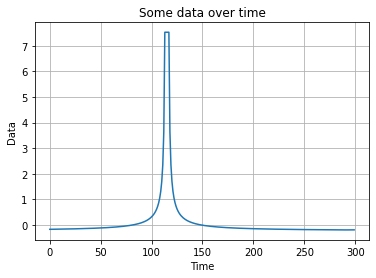

In [110]:
# Plot data

plot_data = raw_data[:, 0][:300]
plt.plot(range(len(plot_data)), plot_data)
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Some data over time')
plt.grid()
plt.show()

### Error Calculation Method

In [0]:
def get_error(forecast, real):
  '''Computes error of forecasted vs real data (L2 norm)
  '''
  #mean = np.mean(np.concatenate((forecast, real), axis=0), axis=0)
  if len(real) < len(forecast):
    forecast = forecast[:len(real)]
  diff = (forecast - real)
  return np.linalg.norm(diff, ord=2, axis=0)

### Single VAR Test With Graph

Let's run VAR on a portion of the data and see how well it can forecast the future

In [0]:
# MULTIPLE VARIABLE MODEL

lag_order = 10

var_data = raw_data
trimmed_data = var_data[:150]
model = VAR(trimmed_data)
results = model.fit(lag_order)
forecasted_data = results.forecast(trimmed_data[-lag_order:], 50)

error = get_error(forecasted_data, var_data[100: 100 + len(forecasted_data)])

In [0]:
# SINGLE VARIABLE MODE

lag_order = 10

var_data = raw_data[:, :1]
model = ARIMA(var_data[:150], order=(lag_order, 0, 0))
fitted = model.fit()
forecasted_data, se, conf = fitted.forecast(50)  # 95% conf

error = get_error(forecasted_data, var_data[470: 470 + len(forecasted_data)])

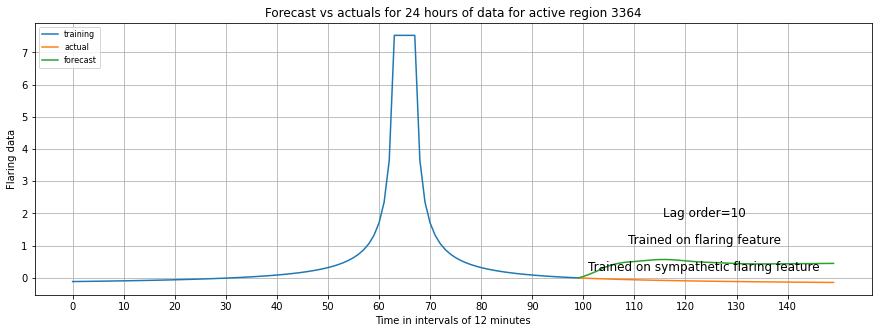

In [123]:
length = 150
trimmed_data = var_data[:length]
i = 0

single_var = False
if single_var:
  fd = forecasted_data
else:
  fd = forecasted_data[:, i]

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

plt.plot(range(100), trimmed_data[:, i][-100:], label='training')
plt.plot(range(100 - 1, 100 + len(fd)),
         var_data[length - 1: length + len(fd)][:, i], 
         label='actual')
plt.plot(range(100 - 1, 100 + len(fd)),
         np.insert(fd, 0, var_data[length - 1:length][:, i], axis=0),
         label='forecast')

plt.xticks(range(0, 150, 10))
plt.xlabel('Time in intervals of 12 minutes')
plt.ylabel('Flaring data')
plt.title('Forecast vs actuals for 24 hours of data for active region 3364')
plt.legend(loc='upper left', fontsize=8)
plt.text(.8, .3, 'Lag order=' + str(lag_order),
         fontsize=12, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(.8, .2, 'Trained on flaring feature',
         fontsize=12, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(.8, .1, 'Trained on sympathetic flaring feature',
         fontsize=12, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.grid()
plt.show()

### Error vs. number of variables

In [0]:
def get_error_for_num_vars(dataset, num_vars, lag_order, n=1000, test_num=10, verbose=True):
  '''Finds the error for a VAR model on a certain dataset by running trials of 
  predicting test_num points n times. Lag order must be specified for the model.
  Returns a list of errors (MRS) of length n.

  If num_vars > 1, will return a list of errors as well as future errors (predicting
  values in the future based on the current model). If num_vars == 1, will only
  return non-future errors and [] in the second argument.
  '''
  random.seed(1729)
  errors = []
  future_errors = []
  num_zero_data = 0  # Count number of examples we skip since they contain zeros
  flare_indices = list(np.where(dataset[:, 0] == max(np.unique(dataset[:, 0])))[0])

  for prog in range(n):
    if prog % 100 == 0 and verbose: print(prog, 'points processed')
    i = random.randint(100, len(dataset))  # Run on random subsets of data

    if num_vars > 1:
      var_data = dataset[:, :num_vars]  # Take the first num_vars variables of dataset
      trimmed_data = var_data[:i]
      model = VAR(trimmed_data)
      try:
        results = model.fit(lag_order)
      except ValueError:
        continue
      forecasted_data = results.forecast(trimmed_data[-lag_order:], test_num)

      real_data = var_data[i: i + len(forecasted_data)]
      prev_real_data = var_data[i - lag_order: i]  # This is the data the model is forecasting on
      if not np.all(real_data) or not np.all(prev_real_data):  # Check for zeros in the real data
        num_zero_data += 1
        continue  # Do not record error if there are zeros
      error = get_error(forecasted_data, real_data)
      errors.append(error)

      # Future data is created by forecasting and testing on data 5 timesteps ahead 
      # of where training ended
      future_forecasted_data = results.forecast(var_data[:i + test_num * 5][-lag_order:],
                                        test_num)
      future_real_data = var_data[i + test_num * 5: i + test_num * 5 + len(forecasted_data)]
      prev_future_real_data = var_data[i + test_num * 5 - lag_order: i + test_num * 5]
      if not np.all(future_real_data) or not np.all(prev_future_real_data):
        continue
      future_error = get_error(future_forecasted_data, future_real_data)
      future_errors.append(future_error)

    if num_vars == 1:  # We need to separate this case since statsmodel VAR
                       # requires there to be at least 2 variables
      var_data = dataset[:, 0]
      trimmed_data = var_data[:i]
      model = ARIMA(trimmed_data, order=(lag_order, 0, 0))
      try:
        fitted = model.fit(method='css')
      except np.linalg.LinAlgError:
        continue
      forecasted_data, se, conf = fitted.forecast(steps=test_num)  # 95% conf
      real_data = var_data[i: i + len(forecasted_data)]
      prev_real_data = var_data[i - lag_order: i]
      if not np.all(real_data) or not np.all(prev_real_data):
        num_zero_data += 1
        continue
      error = get_error(forecasted_data, real_data)
      errors.append(error)

  if num_vars == 1: return np.array(errors), []
  else: return np.array(errors), np.array(future_errors)

In [128]:
num_vars = 2
lag_order = 1
errors, future_errors = get_error_for_num_vars(raw_data, num_vars, lag_order,
                                               n=100, test_num=10, verbose=True)

index = 0
if len(future_errors) > 0:
  print('Mean error:', np.mean(errors[:, index]))
  print('Mean future error:', np.mean(future_errors[:, index]))
else:
  print('Mean error:', np.mean(errors))

0 points processed
Mean error: 0.6096012103665154
Mean future error: 0.6482367336230616


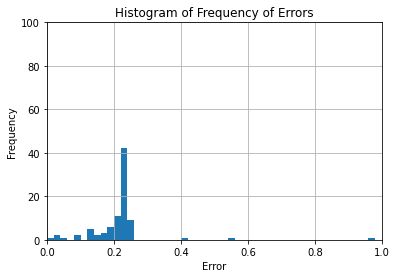

In [129]:
binsrange = 0.02 * np.array(range(51))

if len(future_errors) > 0:
  plt.hist(errors[:, 0], bins=binsrange)
else:
  plt.hist(errors, bins=binsrange)
plt.title('Histogram of Frequency of Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 100])
plt.grid()
plt.show()